**Note**
* SC inherently utilizes overlapping profiles. The contribution from a non-overlapping profile $m_j$ to approximate $m_i$ will likely be small since for a large portion of the time axis $m_j = 0$ where $m_j \neq 0$. Consequently, $\beta_j$ will be small.

**Conclusions**
* Clustering SC coefficients cannot discriminate between profiles.
* K-means clustering of profiles directly gives pretty intuitive results.
* Looking at k-means centroids shows that profiles are mainly separated by time shift.

In [1]:
import sys
sys.path.append("../src/")

from time import time 

from scipy import signal
from scipy.sparse import csgraph

from sklearn.metrics import jaccard_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cluster import SpectralClustering

import numpy as np 
import matplotlib.pyplot as plt

from graph_learning import (
    annealing, aquisition, utils, profile_synthesis
)

%matplotlib inline

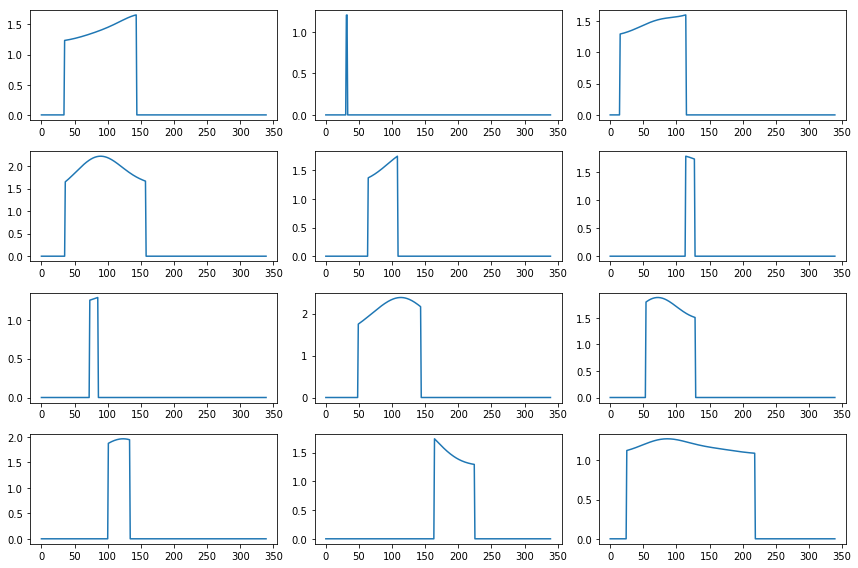

In [31]:
def interpolation_region_mask(Y):
    
    O = np.zeros_like(Y)
    for i, y in enumerate(Y):
        
        t_start = np.argmax(Y[i] != 0)
        t_end = np.argmax(np.cumsum(Y[i])) + 1
        
        O[i, t_start:t_end] = 1
        
    return O


def synthetic_data_gen():
    
    M = np.load("../data/M_train.npy")
    Y = np.load("../data/X_train.npy")
    #Z = np.load("../data/graph_learning/Z.npy")
    #A = np.load("../data/graph_learning/A.npy")
    
    O = interpolation_region_mask(Y)

    return M * O
    
    
def screening_data_gen():
    
    M = np.load("/Users/sela/Desktop/recsys_paper/results/screening/mf/train/train_Xrec.npy")
    Y = np.load("/Users/sela/Desktop/recsys_paper/data/screening/train/X_train.npy")
    O = interpolation_region_mask(Y)

    return M * O


# Choose between synthetic and screening data for demonstration run.
M = synthetic_data_gen()
#M = screening_data_gen()

# TEMP:
M = M[:2000]

# Examples of profiles.
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 8))
for i, axis in enumerate(axes.ravel()):
    axis.plot(M[i])
plt.tight_layout()

In [32]:
M.shape

(2000, 340)

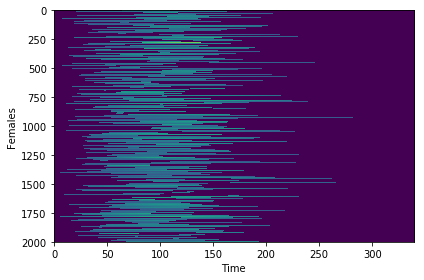

In [33]:
plt.figure()
plt.imshow(M, aspect="auto")
plt.xlabel("Time"); plt.ylabel("Females")
plt.tight_layout()

In [34]:
def loss(M, M_hat):
    
    return np.linalg.norm(np.array(M) - np.array(M_hat)) ** 2

# Clustering SC coefficients 

In [35]:
def synthesize(i, m_i, M_j, alpha=0.01, return_coef=True):
    
    #model = LinearRegression(fit_intercept=False)
    model = Ridge(alpha=alpha, fit_intercept=False)
    #model = Lasso(alpha=alpha, fit_intercept=False, max_iter=20000)
    model.fit(np.transpose(M_j), m_i)

    m_hat = np.transpose(M_j) @ model.coef_

    if return_coef:
        return m_hat, model.coef_
    
    return m_hat

In [7]:
"""
opt_alpha, opt_loss, losses = None, np.inf, []

alphas = 10 ** np.linspace(-4, 2, 10)
for alpha in alphas:
    
    M_i, M_i_hat = [], []
    for i, m_i in enumerate(M):

        # Exclude i from donor pool. 
        N_i = np.concatenate([np.arange(i), np.arange(i + 1, M.shape[0])])
    
        m_i_hat, beta_i = synthesize(i, M[i], M[N_i], alpha=alpha)

        M_i.append(M[i])
        M_i_hat.append(m_i_hat)
        
    loss_alpha_i = loss(M_i, M_i_hat)
    if loss_alpha_i < opt_loss:
        
        opt_loss = loss_alpha_i
        opt_alpha = alpha
    
    losses.append(loss_alpha_i)
    
print(opt_loss, opt_alpha)

plt.figure()
plt.plot(losses, "-o")
plt.xlabel(r"Regularisation parameter $\alpha$")
plt.ylabel(r"Loss $\left \| M - \hat{M} \right \|$")
plt.tight_layout()
"""

'\nopt_alpha, opt_loss, losses = None, np.inf, []\n\nalphas = 10 ** np.linspace(-4, 2, 10)\nfor alpha in alphas:\n    \n    M_i, M_i_hat = [], []\n    for i, m_i in enumerate(M):\n\n        # Exclude i from donor pool. \n        N_i = np.concatenate([np.arange(i), np.arange(i + 1, M.shape[0])])\n    \n        m_i_hat, beta_i = synthesize(i, M[i], M[N_i], alpha=alpha)\n\n        M_i.append(M[i])\n        M_i_hat.append(m_i_hat)\n        \n    loss_alpha_i = loss(M_i, M_i_hat)\n    if loss_alpha_i < opt_loss:\n        \n        opt_loss = loss_alpha_i\n        opt_alpha = alpha\n    \n    losses.append(loss_alpha_i)\n    \nprint(opt_loss, opt_alpha)\n\nplt.figure()\nplt.plot(losses, "-o")\nplt.xlabel(r"Regularisation parameter $\x07lpha$")\nplt.ylabel(r"Loss $\\left \\| M - \\hat{M} \right \\|$")\nplt.tight_layout()\n'

Duration over 2000 samples: 10.49257779121399
557 False
-1.1313588892008535 0.0003988950571656217 1.4777619651856957
1.1342225769706005e-11 0.0021558507817100495 1.4777619651856957
-0.0005680219489781896 2.1467024259695655e-06 0.000508529730476456


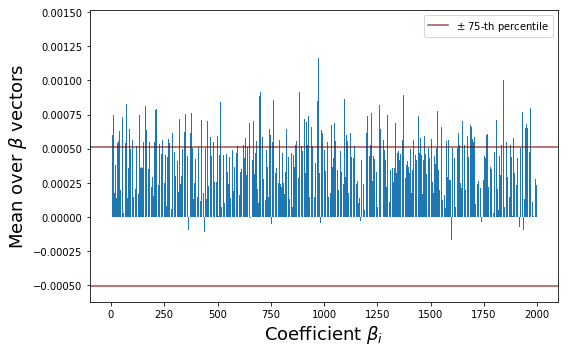

In [49]:
# TEMP:
opt_alpha = 0.001
###

# Approximate coefficients for each profile in the dataset.
betas, M_i_hat = [], []
t0 = time()
for i, m_i in enumerate(M):
    
    # Exclude i from donor pool. 
    N_i = np.concatenate([np.arange(i), np.arange(i + 1, M.shape[0])])
    
    m_i_hat, beta_i = synthesize(i, M[i], M[N_i], alpha=opt_alpha)
    
    M_i_hat.append(m_i_hat)
    
    betas.append(beta_i)
    
betas = np.array(betas)
    
print(f"Duration over {M.shape[0]} samples:", time() - t0)

print(np.sum(np.isclose(betas, 0)), np.isnan(np.min(betas)))
print(np.min(betas), np.mean(betas), np.max(betas))
print(np.min(np.abs(betas)), np.mean(np.abs(betas)), np.max(np.abs(betas)))
print(np.quantile(betas, 0.25), np.quantile(betas, 0.5), np.quantile(betas, 0.75))

avg_betas = np.mean(betas, axis=0)

plt.figure(figsize=(8, 5))
plt.bar(np.arange(len(avg_betas)), avg_betas)
plt.axhline(y=np.quantile(betas, 0.75), c="maroon", alpha=0.7, label=r"$\pm$ 75-th percentile")
plt.axhline(y=-np.quantile(betas, 0.75), c="maroon", alpha=0.7)
plt.xlabel(r"Coefficient $\beta_i$", fontsize=18)
plt.ylabel(r"Mean over $\beta$ vectors", fontsize=18)
plt.legend()
plt.tight_layout()

In [38]:
betas.shape

(2000, 1999)

$\beta_i : M_j^\top \beta_i \approx m_i$

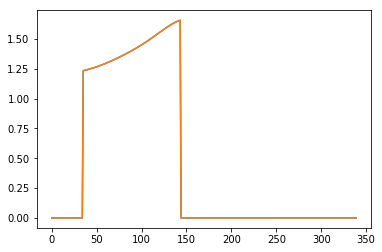

In [39]:
# Sanity check.
i = 0
N_i = np.concatenate([np.arange(i), np.arange(i + 1, M.shape[0])])

plt.figure()
plt.plot(M[i])
plt.plot(M[N_i].T @ betas[i])

# K-means clustering of profile coefficients

* Assign each coefficient vector $\beta_i$ for some $m_i$ to a cluster.

In [40]:
from sklearn.cluster import KMeans

In [50]:
cluster_inertia = []

num_clusters = np.arange(1, 20)
for n_clusters in num_clusters:
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(betas)
    
    cluster_inertia.append(kmeans.inertia_)

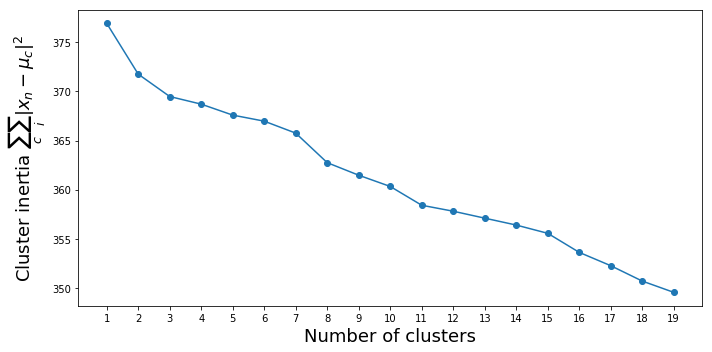

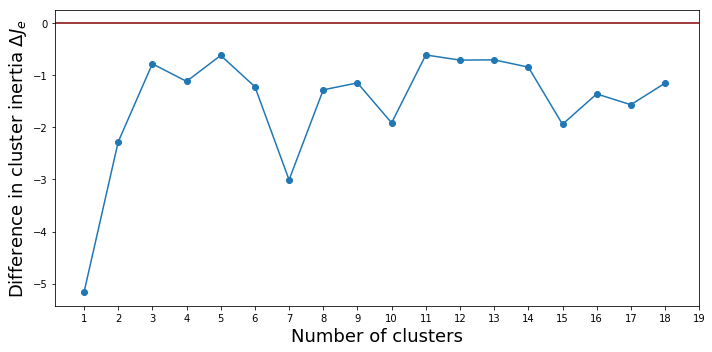

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(cluster_inertia, "-o")
plt.xlabel("Number of clusters", fontsize=18)
plt.ylabel(r"Cluster inertia $\sum_c \sum_i \left \| x_n - \mu_c \right \|^2$",
          fontsize=18)
plt.xticks(num_clusters - 1, num_clusters)
plt.tight_layout()

plt.figure(figsize=(10, 5))
plt.plot(np.diff(cluster_inertia), "-o")
plt.xlabel("Number of clusters", fontsize=18)
plt.ylabel(r"Difference in cluster inertia $\Delta J_e$",
          fontsize=18)
plt.axhline(y=0, c="maroon")
plt.xticks(num_clusters - 1, num_clusters)
plt.tight_layout()

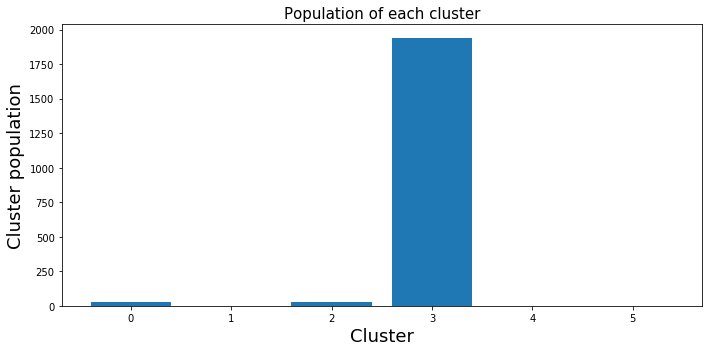

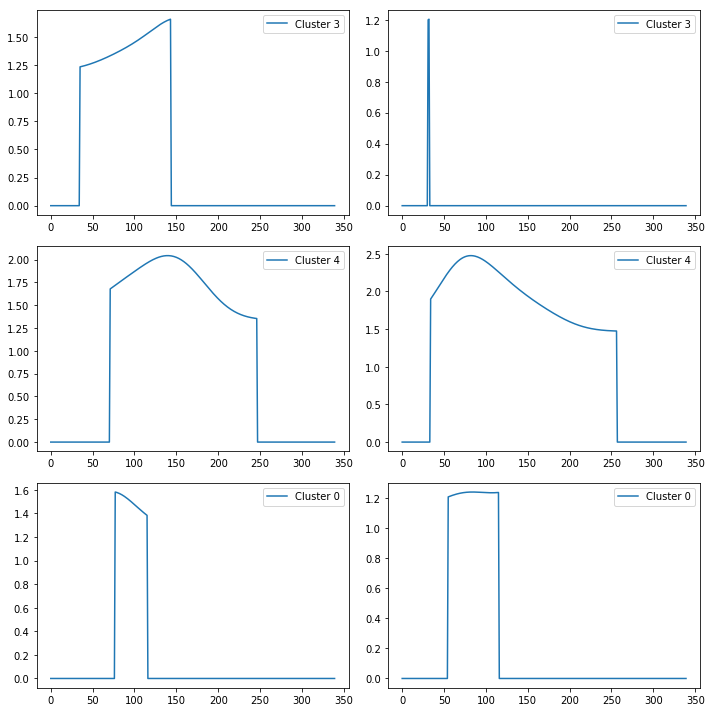

In [52]:
kmeans_final = KMeans(n_clusters=6, random_state=42)
kmeans_final.fit(betas)

labels, counts = np.unique(kmeans_final.labels_, return_counts=True)

plt.figure(figsize=(10, 5))
plt.title("Population of each cluster", fontsize=15)
plt.bar(labels, counts)
plt.xlabel("Cluster", fontsize=18)
plt.ylabel("Cluster population", fontsize=18)
plt.tight_layout()

np.random.seed(42)

nrows = 3
_, axes = plt.subplots(ncols=2, nrows=nrows, figsize=(10, 10))
for i in range(nrows):

    cluster = np.random.choice(labels[counts >= 2])
        
    axes[i, 0].plot(M[kmeans_final.labels_ == cluster][0], label=f"Cluster {cluster}")
    axes[i, 1].plot(M[kmeans_final.labels_ == cluster][1], label=f"Cluster {cluster}")
    axes[i, 0].legend(); axes[i, 1].legend()
plt.tight_layout()

# Agglomerative clustering

In [53]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [54]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

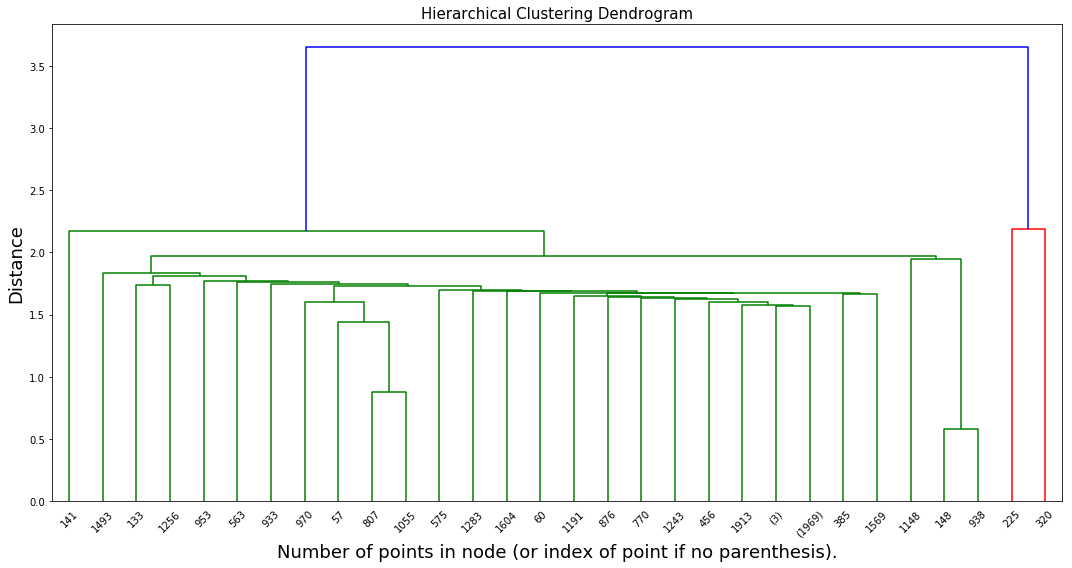

In [55]:
# Setting distance_threshold=0 ensures we compute the full tree.
agglom = AgglomerativeClustering(distance_threshold=0, n_clusters=None,
                                 affinity="euclidean")
agglom.fit(betas)

plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram', fontsize=15)
# Plot the top `p` levels of the dendrogram.
plot_dendrogram(agglom, truncate_mode='level', p=20)
plt.xlabel("Number of points in node (or index of point if no parenthesis).",
          fontsize=18)
plt.ylabel("Distance", fontsize=18)
plt.axhline(y=10, c="maroon")
plt.tight_layout()

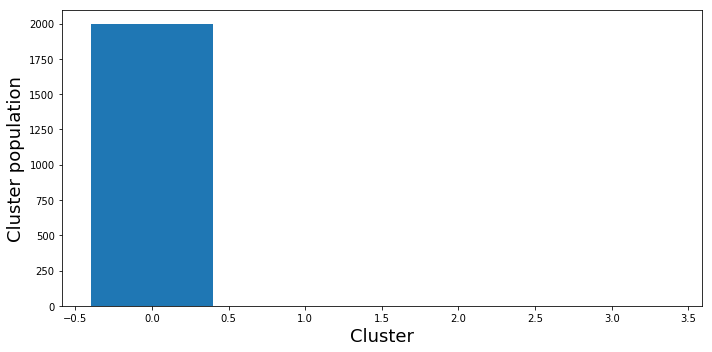

In [56]:
# Setting distance_threshold=0 ensures we compute the full tree.
agglom = AgglomerativeClustering(n_clusters=4, affinity="euclidean")
agglom.fit_predict(betas)

labels, counts = np.unique(agglom.labels_, return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(labels, counts)
plt.xlabel("Cluster", fontsize=18)
plt.ylabel("Cluster population", fontsize=18)
plt.tight_layout()

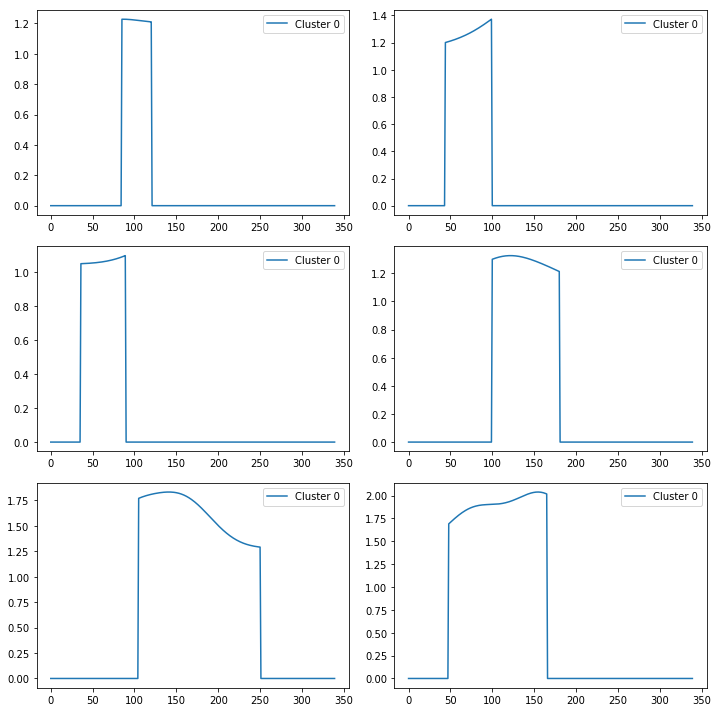

In [57]:
np.random.seed(42)

nrows = 3
_, axes = plt.subplots(ncols=2, nrows=nrows, figsize=(10, 10))
for i in range(nrows):

    cluster = np.random.choice(labels[counts >= 2])
    
    M_cluster = M[agglom.labels_ == cluster]
    idx = np.random.choice(M_cluster.shape[0], replace=False, size=2)
    
    axes[i, 0].plot(M_cluster[idx[0]], label=f"Cluster {cluster}")
    axes[i, 1].plot(M_cluster[idx[1]], label=f"Cluster {cluster}")
    axes[i, 0].legend(); axes[i, 1].legend()
plt.tight_layout()

# Clustering profiles directly

In [63]:
#M = synthetic_data_gen()
M = screening_data_gen()

# TEMP:
M = M[:4000]

cluster_inertia = []

num_clusters = np.arange(1, 20)
for n_clusters in num_clusters:
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(M)
    
    cluster_inertia.append(kmeans.inertia_)

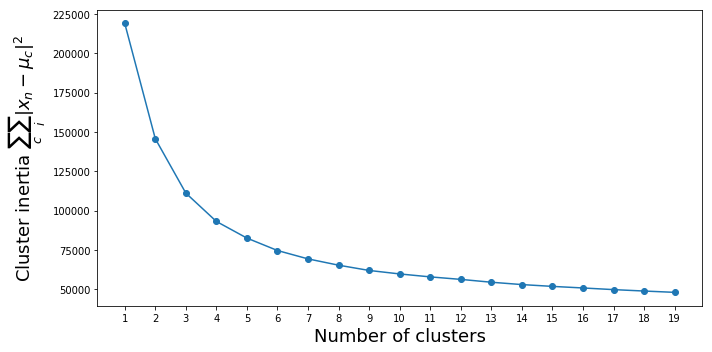

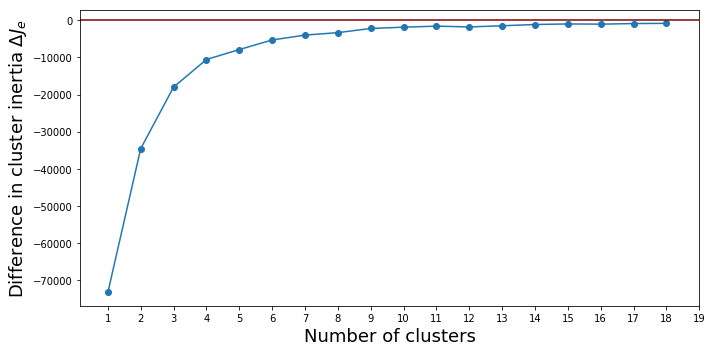

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(cluster_inertia, "-o")
plt.xlabel("Number of clusters", fontsize=18)
plt.ylabel(r"Cluster inertia $\sum_c \sum_i \left \| x_n - \mu_c \right \|^2$",
          fontsize=18)
plt.xticks(num_clusters - 1, num_clusters)
plt.tight_layout()

plt.figure(figsize=(10, 5))
plt.plot(np.diff(cluster_inertia), "-o")
plt.xlabel("Number of clusters", fontsize=18)
plt.ylabel(r"Difference in cluster inertia $\Delta J_e$",
          fontsize=18)
plt.axhline(y=0, c="maroon")
plt.xticks(num_clusters - 1, num_clusters)
plt.tight_layout()

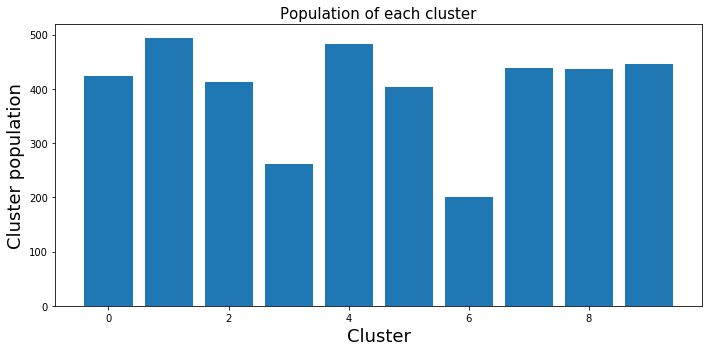

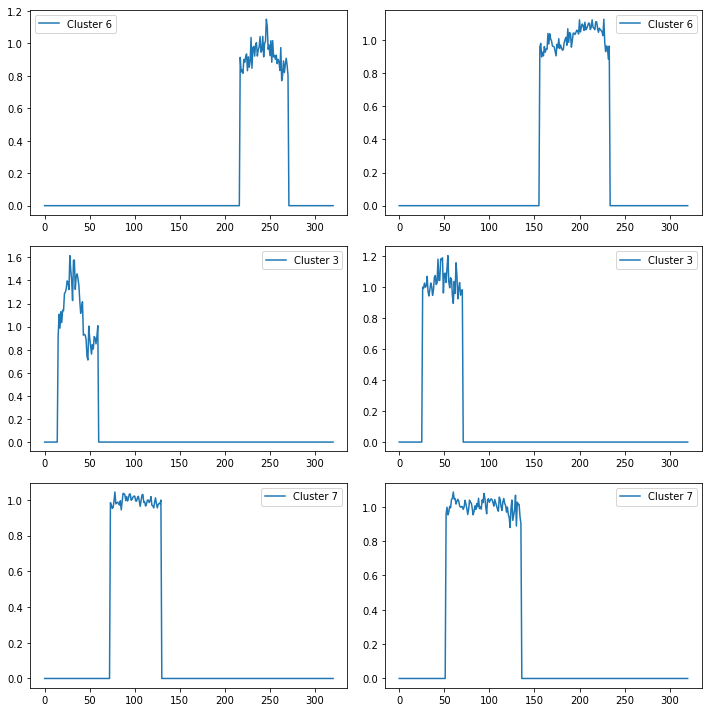

In [76]:
kmeans_final = KMeans(n_clusters=10, random_state=42)
kmeans_final.fit(M)

labels, counts = np.unique(kmeans_final.labels_, return_counts=True)

plt.figure(figsize=(10, 5))
plt.title("Population of each cluster", fontsize=15)
plt.bar(labels, counts)
plt.xlabel("Cluster", fontsize=18)
plt.ylabel("Cluster population", fontsize=18)
plt.tight_layout()

np.random.seed(42)

nrows = 3
_, axes = plt.subplots(ncols=2, nrows=nrows, figsize=(10, 10))
for i in range(nrows):

    cluster = np.random.choice(labels[counts >= 2])
        
    axes[i, 0].plot(M[kmeans_final.labels_ == cluster][0], label=f"Cluster {cluster}")
    axes[i, 1].plot(M[kmeans_final.labels_ == cluster][1], label=f"Cluster {cluster}")
    axes[i, 0].legend(); axes[i, 1].legend()
plt.tight_layout()

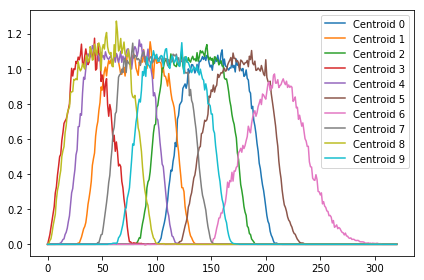

In [77]:
plt.figure()
for i, c in enumerate(kmeans_final.cluster_centers_):
    plt.plot(c, label=f"Centroid {i}")
    
plt.legend()
plt.tight_layout()

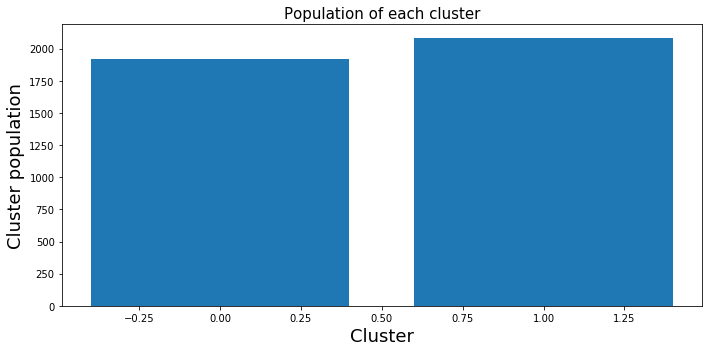

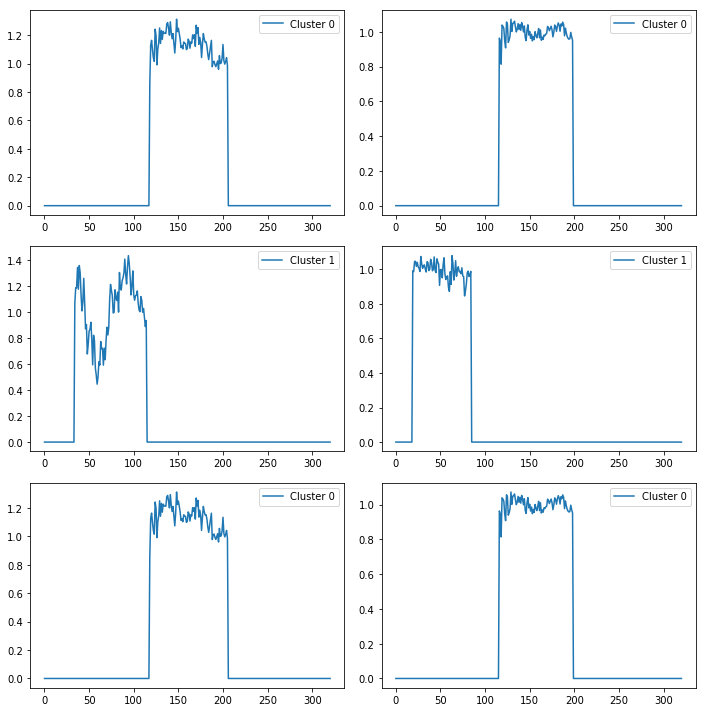

In [68]:
kmeans_final = KMeans(n_clusters=2, random_state=42)
kmeans_final.fit(M)

labels, counts = np.unique(kmeans_final.labels_, return_counts=True)

plt.figure(figsize=(10, 5))
plt.title("Population of each cluster", fontsize=15)
plt.bar(labels, counts)
plt.xlabel("Cluster", fontsize=18)
plt.ylabel("Cluster population", fontsize=18)
plt.tight_layout()

np.random.seed(42)

nrows = 3
_, axes = plt.subplots(ncols=2, nrows=nrows, figsize=(10, 10))
for i in range(nrows):

    cluster = np.random.choice(labels[counts >= 2])
        
    axes[i, 0].plot(M[kmeans_final.labels_ == cluster][0], label=f"Cluster {cluster}")
    axes[i, 1].plot(M[kmeans_final.labels_ == cluster][1], label=f"Cluster {cluster}")
    axes[i, 0].legend(); axes[i, 1].legend()
plt.tight_layout()

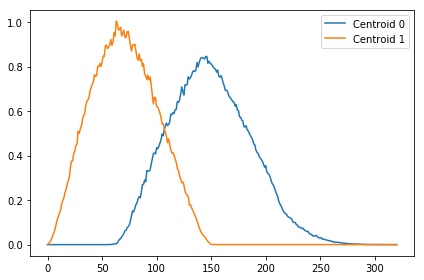

In [75]:
plt.figure()
for i, c in enumerate(kmeans_final.cluster_centers_):
    plt.plot(c, label=f"Centroid {i}")
    
plt.legend()
plt.tight_layout()

# Clustering time-shifted profiles

In [78]:
import tslearn

ModuleNotFoundError: No module named 'tslearn'